In [1]:
from models import FeedforwardNeuralNetModel, TinyCNN, PatternClassifier
from torchvision import datasets, transforms
from torch import optim
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import copy
from utils import *
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

import seaborn as sns
colors = sns.color_palette("tab10")

#configs
epochs = 3
batch_size = 10000
test_batch_size = 10000
use_cuda = True
lr = 1
log_interval = 100
LOAD = True
LOADPATH = 'TinyCNN15:36:27'

#torch specific configs
torch.manual_seed(1)

device = torch.device("cuda")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Agenda
### Big question: CFI for NN

### Backlog RQs: 
- BRQ1: Can we look at a random k entries in the weight instead of the first k?
- BRQ2: What if we set all the small abs weight in the Pattern classifer to 0? what is the accuracy in that case?
- BRQ3: Given an image and an l2-ball surrounding it, how many activation maps are there? (closely related to RQ1)
- BRQ4: Given a simple attacking method (e.g, Fast gradient sign), build a dataset of activation maps of true and fake digits. Try to train a pattern classifier using that dataset.

In [59]:
# Load the pretrained model
dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

# model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
model = TinyCNN().to(device)

if LOAD:
    model.load_state_dict(torch.load(LOADPATH))


## RQ1: given 2 close images, how close are their activation patterns?
### Some definition: 
- close images are defined by L2-norm (a parameter, can be changed to something else)
- close activation patterns are defined by first take the XOR of the 2 patterns (both are binary mask), then take the sum (basically we count how many bits are different between the two patterns)

### Result summary: 
- Given 2 close images, their activation patterns are significantly closer than with a random one. This is expected
- Layer by layer, conv2 contains the most amount of difference. This is unexpected. My expectation is conv1 > conv2 > fc1 > fc2, but the actual order across many samples are conv2 > conv1 > fc1 > fc2


10000
torch.Size([1, 28, 28])
torch.Size([10000, 1, 28, 28])
model output for s1: tensor(1, device='cuda:0')
model output for s2: tensor(1, device='cuda:0')


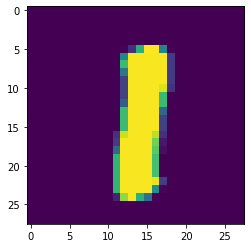

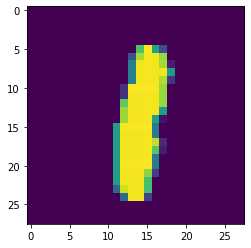

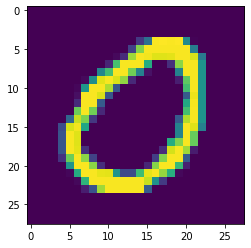

In [45]:
#sample 2 close images and a random one
s1, s2, d = sample_pair(train_loader)
random, _ = next(iter(train_loader))
random = random[0]

#plot images for sanity check
plt.figure(); plt.imshow(s1.squeeze())
plt.figure(); plt.imshow(s2.squeeze())
plt.figure(); plt.imshow(random.squeeze())

#run the model to check the output are expected
print("model output for s1:", model(s1.unsqueeze(0).to(device)).argmax())
print("model output for s2:", model(s2.unsqueeze(0).to(device)).argmax())

In [58]:
print(d)
s1_raw_pattern = get_pattern(model, device, s1.unsqueeze(0))
s2_raw_pattern = get_pattern(model, device, s2.unsqueeze(0))
random_raw_pattern = get_pattern(model, device, random.unsqueeze(0))
layers = ['conv1', 'conv2', 'fc1', 'fc2']

def bit_diff(a, b):
    return np.logical_xor(a, b).sum()
for layer in layers:
    s1_pattern = np.concatenate([s1_raw_pattern[l] for l in [layer]], axis = 1)
    s2_pattern = np.concatenate([s2_raw_pattern[l] for l in [layer]], axis = 1)
    random_pattern = np.concatenate([random_raw_pattern[l] for l in [layer]], axis = 1)
    print("vs s2:", layer, bit_diff(s1_pattern, s2_pattern), "/", len(s1_pattern[0]), bit_diff(s1_pattern, s2_pattern)/len(s1_pattern[0]))
#     print("vs random:",layer, np.logical_xor(s1_pattern, random_pattern).sum(), "/", len(s1_pattern[0]))

tensor(8.7786)
vs s2: conv1 101 / 2704 0.03735207100591716
vs s2: conv2 304 / 4608 0.06597222222222222
vs s2: fc1 1 / 16 0.0625
vs s2: fc2 0 / 10 0.0


## RQ2: Is it possible for an adv example to have activation pattern close to the real one?
hypothesis: an adv example should have pattern that is very different from a real one.

subtask 1: generate a adv example

subtask 2: get its pattern, compare to ALL existing patterns, find the min. How big/small is the min?

subtask 3a: if the min is kinda big, check if it is actually big for many adv examples

subtask 3b: if the min is small, what is the closest activation pattern. what original input does it correspond to?

status: in progress

### Result summary
All of the below results are based on adv generated by Fast Sign Gradient attack, with a fixed epsilon = 0.7 (one or two examples are done with epsilon = 0.5)
- The resulted adv example trigger a very different activation pattern compared with the victim
- consistently ~60% diff in conv1 and ~30% in conv2 for eps = 0.7. 
- Interesting because in close images, diff in conv1 < diff in conv2
- The resulted adv example trigger an activation pattern that is not close to any real activation pattern. The min number of difference bit is consistantly > 2000, and for real images they are < 1000

Epsilon: 0.5	Test Accuracy = 1 / 1 = 1.0
Epsilon: 0.5	Test Accuracy = 1 / 1 = 1.0
Epsilon: 0.5	Test Accuracy = 1 / 1 = 1.0
Epsilon: 0.5	Test Accuracy = 1 / 1 = 1.0
Epsilon: 0.5	Test Accuracy = 1 / 1 = 1.0
Epsilon: 0.5	Test Accuracy = 1 / 1 = 1.0
Epsilon: 0.5	Test Accuracy = 1 / 1 = 1.0
Epsilon: 0.5	Test Accuracy = 1 / 1 = 1.0
Epsilon: 0.5	Test Accuracy = 1 / 1 = 1.0
Epsilon: 0.5	Test Accuracy = 1 / 1 = 1.0
Epsilon: 0.5	Test Accuracy = 1 / 1 = 1.0
Epsilon: 0.5	Test Accuracy = 1 / 1 = 1.0
Epsilon: 0.5	Test Accuracy = 1 / 1 = 1.0
Epsilon: 0.5	Test Accuracy = 1 / 1 = 1.0
Epsilon: 0.5	Test Accuracy = 1 / 1 = 1.0
Epsilon: 0.5	Test Accuracy = 1 / 1 = 1.0
Epsilon: 0.5	Test Accuracy = 1 / 1 = 1.0
Epsilon: 0.5	Test Accuracy = 1 / 1 = 1.0
Epsilon: 0.5	Test Accuracy = 0 / 1 = 0.0
4
vs adv: conv1 1617 / 2704 0.5980029585798816
vs adv: conv2 1046 / 4608 0.2269965277777778
vs adv: fc1 2 / 16 0.125
vs adv: fc2 4 / 10 0.4


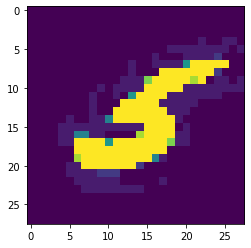

In [97]:
#gen adv exp for victim
while True:
    random, _ = next(iter(train_loader))
    victim = random[0]
    acc, ex = gen_adv(model, device, [(victim.unsqueeze(0), model(victim.unsqueeze(0).to(device)).argmax().unsqueeze(0))], 0.5)
    if len(ex)>0: break

victim_raw_pattern = get_pattern(model, device, victim.unsqueeze(0))

plt.figure(); plt.imshow(ex[0][2])
print(ex[0][1])

adv_exp = ex[0][2]

#get the pattern of the adv example
adv_raw_pattern = get_pattern(model, device, torch.Tensor(adv_exp).unsqueeze(0).unsqueeze(0))

#compare with the victim example
for layer in layers:
    victim_pattern = np.concatenate([victim_raw_pattern[l] for l in [layer]], axis = 1)
    adv_pattern = np.concatenate([adv_raw_pattern[l] for l in [layer]], axis = 1)
    print("vs adv:", layer, bit_diff(victim_pattern, adv_pattern), "/", len(victim_pattern[0]), bit_diff(victim_pattern, adv_pattern)/len(victim_pattern[0]))


In [98]:
#pre-compute all activation
train_dataset = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)

patterns_dataset = get_pattern_dataset(train_dataset, train_dataset.targets, model, layers, train_kwargs)



In [122]:
n_dps = patterns_dataset.patterns.shape[0]
adv_pattern_flatten = np.concatenate([adv_raw_pattern[l] for l in layers], axis =1)
print(adv_pattern_flatten.shape)
adv_tiled = np.tile(adv_pattern_flatten, (n_dps, 1))
adv_tiled.shape

adv_vs_all = np.sum(np.logical_xor(adv_tiled, patterns_dataset.patterns), axis=1)
print(adv_vs_all.min())

all_vs_adv = np.sum(np.logical_xor(patterns_dataset.patterns, adv_tiled), axis=1)
print(all_vs_adv.min())

In [134]:
#compare with a random image
random, _ = next(iter(train_loader))
random = random[0]
random_raw_pattern = get_pattern(model, device, random.unsqueeze(0))
random_pattern_flatten = np.concatenate([random_raw_pattern[l] for l in layers], axis =1)

random_tiled = np.tile(random_pattern_flatten, (n_dps, 1))
all_vs_random = np.sum(np.logical_xor(patterns_dataset.patterns, random_tiled), axis=1)
print(sorted(list(all_vs_random))[1])

322
